In [1]:
%matplotlib inline

import pickle
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

In [7]:
xs = []
ys = []
for i in tqdm(range(5)):
    fn = f'../../data/cifar-10-batches-py/data_batch_{i+1}'
    with open(fn, 'rb') as f:
        res = pickle.load(f, encoding='bytes')
        xs.append(res[b'data'])
        ys.append(res[b'labels'])
        
xs = np.vstack(xs).astype(np.float32)
ys = np.hstack(ys).astype(np.uint32)

print(xs.shape)
print(ys.shape)

100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


(50000, 3072)
(50000,)


In [8]:
%%time

x_train, x_valid, y_train, y_valid = \
    train_test_split(xs, ys, test_size=0.2, random_state=42)

std = StandardScaler()
std.fit(x_train)
xt_std = std.transform(x_train)
xv_std = std.transform(x_valid)

pca = PCA(n_components=20)
pca.fit(x_train)
xt_pca = pca.transform(x_train)
xv_pca = pca.transform(x_valid)
print(pca.explained_variance_ratio_.sum())

xt, xv = xt_pca, xv_pca
yt, yv = y_train, y_valid

print(xt.shape, yt.shape)
print(xv.shape, yv.shape)

0.744511
(40000, 20) (40000,)
(10000, 20) (10000,)
CPU times: user 20.1 s, sys: 10.1 s, total: 30.2 s
Wall time: 11.1 s


In [ ]:
%%time

params = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [1e-2, 1e-1, 1, 10, 100],
    'gamma': [1e-3, 1e-2, 1e-1, 1, 10],    
},

clf = GridSearchCV(SVC(), params, cv=2, scoring='accuracy', 
                   n_jobs=2, return_train_score=True)
clf.fit(xt[:500], yt[:500])
print('Best Param:', clf.best_params_)
print('Best Model Score:', clf.best_estimator_.score(xv, yv))

with open('gridcv.pkl', 'wb') as f:
    pickle.dump(clf, f)

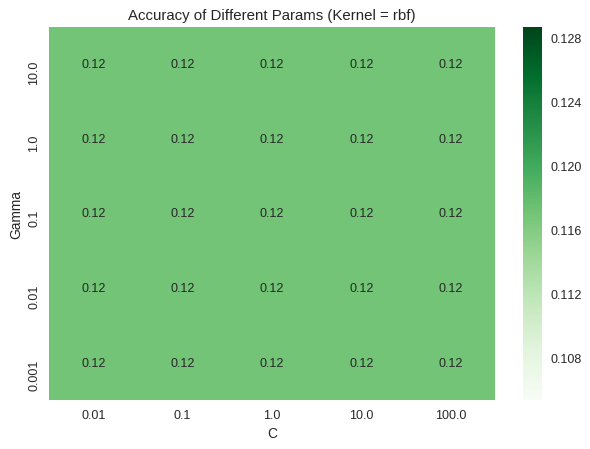

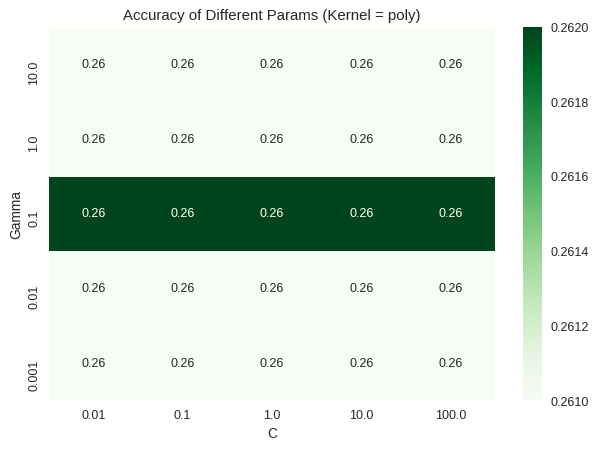

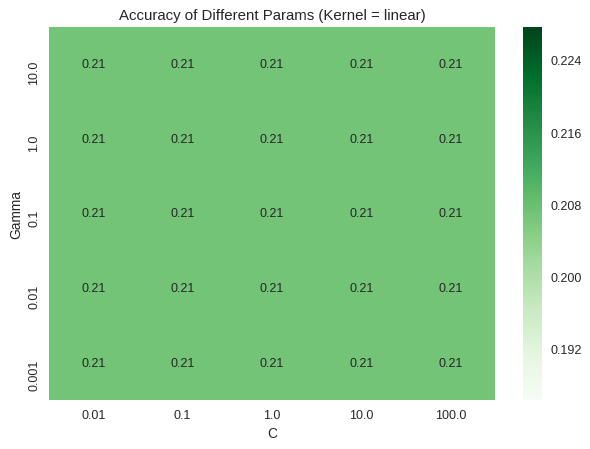

In [2]:
with open('gridcv.pkl', 'rb') as f:
    clf = pickle.load(f)
data = pd.DataFrame(clf.cv_results_)

for k in ['rbf', 'poly', 'linear']:
    df = data[data['param_kernel'] == k]
    df = df.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

    fig, ax = plt.subplots(dpi=90)
    sns.heatmap(df, ax=ax, annot=True, cmap=plt.cm.Greens)
    ax.set_xlabel('C')
    ax.set_ylabel('Gamma')
    ax.set_title('Accuracy of Different Params (Kernel = {})'.format(k))
    ax.invert_yaxis()
    fig.savefig(f'svm_{k}.png')
    plt.show()

In [10]:
%%time
rf = RandomForestClassifier(n_estimators=20)
rf.fit(xt, yt)
rf_pred = rf.predict(xv)
rf_acc = rf.score(xv, yv)
print(classification_report(yv, rf_pred))

             precision    recall  f1-score   support

          0       0.42      0.49      0.45       973
          1       0.41      0.50      0.45       979
          2       0.31      0.30      0.31      1030
          3       0.28      0.26      0.27      1023
          4       0.31      0.33      0.32       933
          5       0.34      0.32      0.33      1015
          6       0.42      0.42      0.42       996
          7       0.45      0.36      0.40       994
          8       0.50      0.51      0.50      1017
          9       0.48      0.43      0.45      1040

avg / total       0.39      0.39      0.39     10000

CPU times: user 4.73 s, sys: 15.9 ms, total: 4.75 s
Wall time: 4.82 s


In [11]:
%%time
svm = clf.best_estimator_
svm_pred = svm.predict(xv)
svm_acc = svm.score(xv, yv)
print(classification_report(yv, svm_pred))

             precision    recall  f1-score   support

          0       0.31      0.37      0.34       973
          1       0.29      0.25      0.27       979
          2       0.19      0.35      0.25      1030
          3       0.18      0.15      0.17      1023
          4       0.19      0.23      0.21       933
          5       0.25      0.18      0.21      1015
          6       0.24      0.25      0.25       996
          7       0.27      0.22      0.24       994
          8       0.41      0.36      0.38      1017
          9       0.35      0.24      0.29      1040

avg / total       0.27      0.26      0.26     10000

CPU times: user 689 ms, sys: 2.21 ms, total: 692 ms
Wall time: 694 ms


In [4]:
def plot2d(xs, ys, ax):
    cmap = plt.cm.tab10_r
    for y in range(10):
        data = xs[ys == y, :]
        ax[y].scatter(data[:, 0], data[:, 1], c=cmap(y / 10), label=y, edgecolors='k')
    return ax

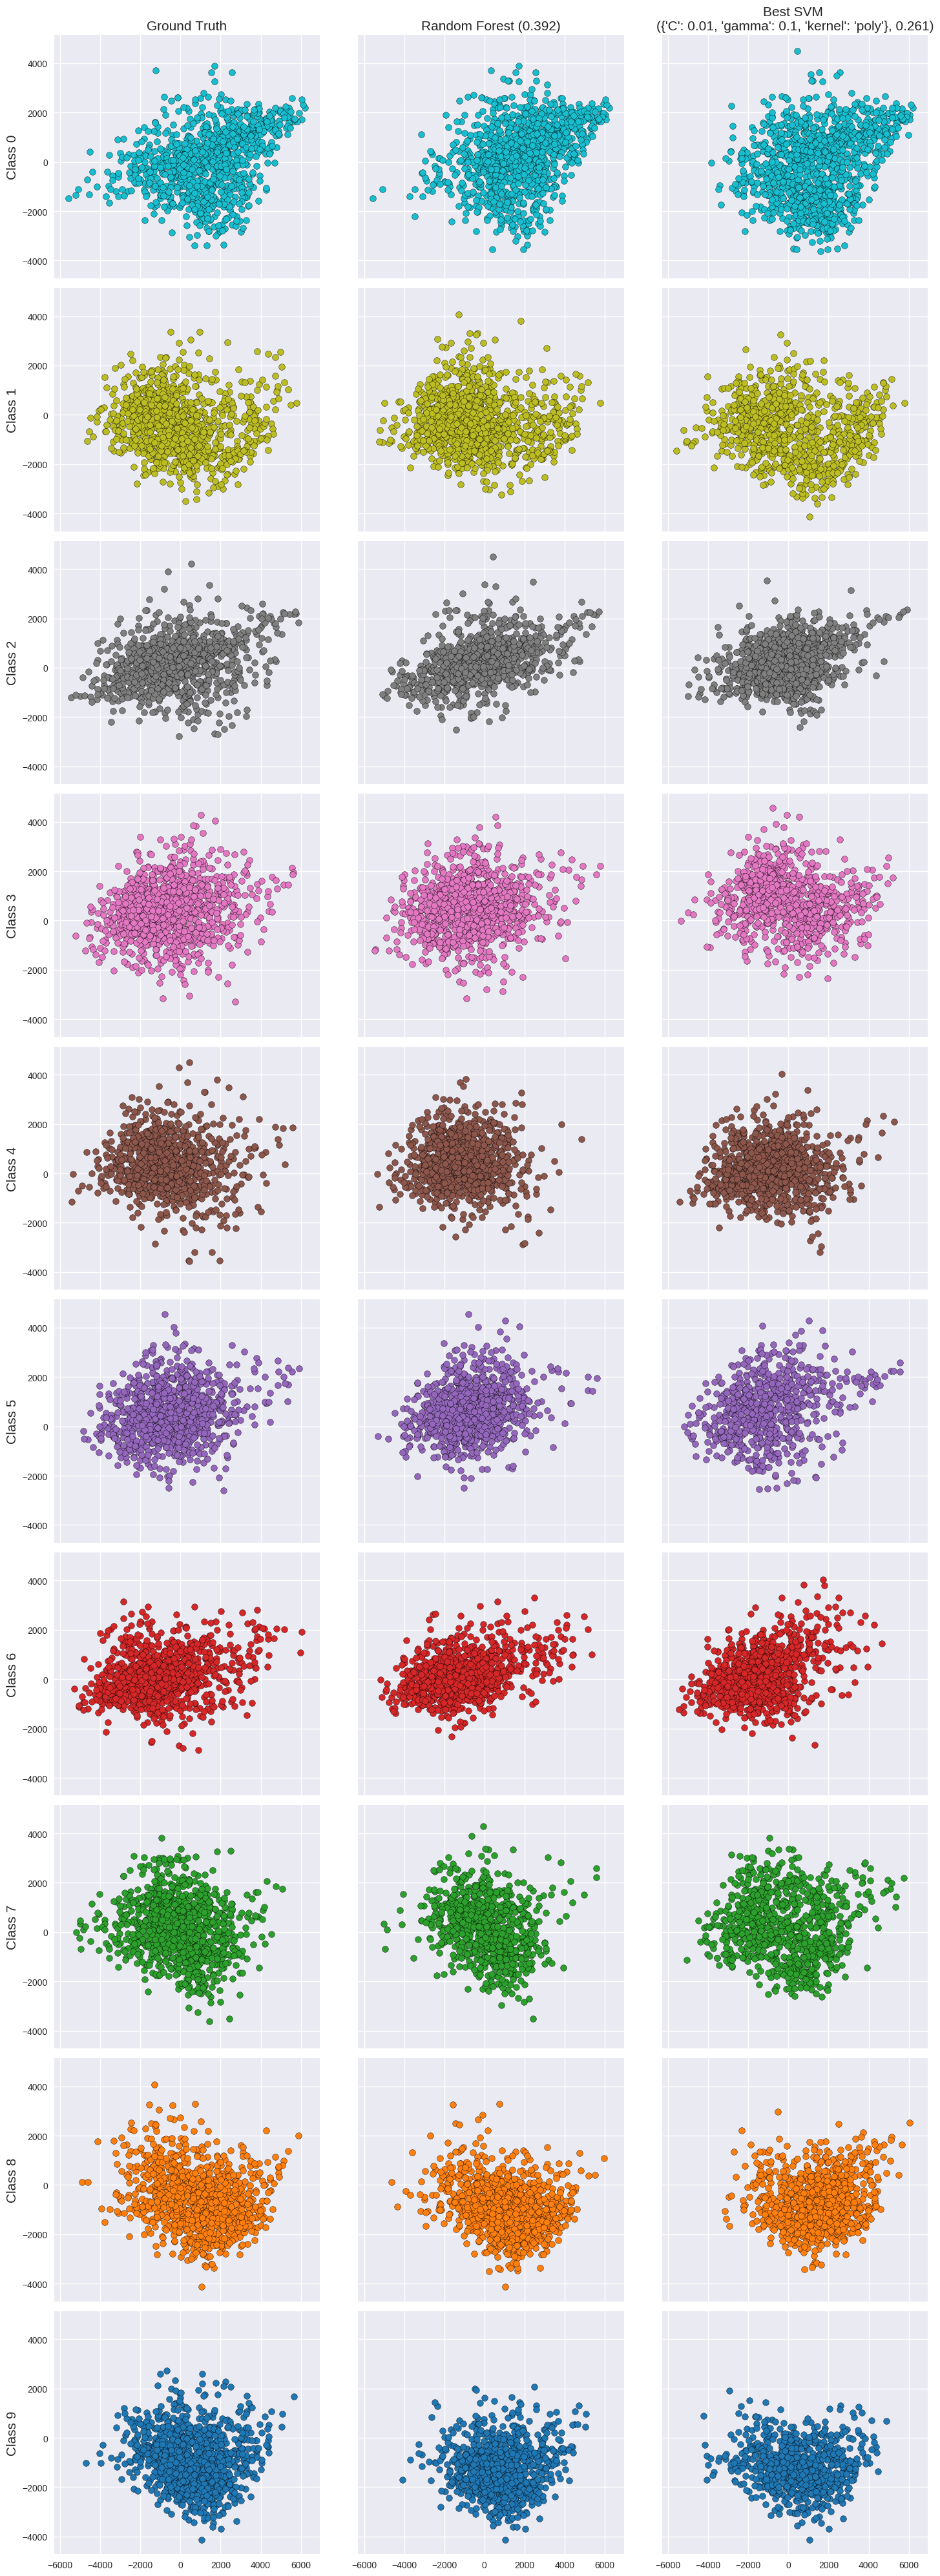

In [13]:
fig, ax = plt.subplots(10, 3, sharex=True, sharey=True, dpi=100, figsize=(15, 40))
plot2d(xv, yv, ax[:, 0])
plot2d(xv, rf_pred, ax[:, 1])
plot2d(xv, svm_pred, ax[:, 2])

col_headers = [f'Class {x}' for x in range(10)]
row_headers = [
    'Ground Truth', 
    f'Random Forest ({rf_acc:.3f})', 
    f'Best SVM \n({clf.best_params_}, {svm_acc:.3f})'
]
for i, rh in enumerate(row_headers):
    ax[0, i].set_title(rh, fontsize=15)
for i, ch in enumerate(col_headers):
    ax[i, 0].set_ylabel(ch, fontsize=15)
    
fig.tight_layout()
fig.savefig('plot.png')
plt.show()